# Preprocess for pty-co-SAXSNN

## Import necessary packages

In [1]:
import sys
from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from matplotlib import colors
import random
from pathlib import Path
import h5py

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from src.utils.preprocessing_functions import log10_custom, apply_mask
plt.rcParams["image.cmap"] = "jet"

## Set and load simulated data (from data_gen.ipynb)

In [ ]:
h5file_data='/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/01_Data_Generation/Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0.50_NoiseOn_Nc10000_Abs0_PhaseScl1.00_ZCB_9_3D_scan5065/sim_ZCB_9_3D_S5065_N60_steps4_dp256.h5'
save_string=h5file_data.split('/')[-2].split('.')[0]+'_'+h5file_data.split('/')[-1].split('.')[0]
print('h5 file and save_string:', save_string)

#save preprocessed data
save=True

# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs")  # on remote server
print(path)

lattice_list=['ClathII','SC',]
noise_list=['Noise','noNoise']
probe_size_list=[128,256]

# Load data directly from the HDF5 file
print(f"Loading data from: {h5file_data}")

with h5py.File(h5file_data, "r") as h5f:
    # Load convDP and idealDP as conv and ideal diffraction patterns
    conv_DPs = h5f['convDP'][:]  # Shape: (10800, 256, 256)
    ideal_DPs = h5f['idealDP'][:]  # Shape: (10800, 256, 256)
    
    num_patterns = len(conv_DPs)
    print(f"Loaded {num_patterns} diffraction patterns")
    print(f"Pattern shapes - conv_DPs: {conv_DPs.shape}, ideal_DPs: {ideal_DPs.shape}")

# Display a random pattern to verify the data
ri = np.random.randint(0, len(conv_DPs))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(conv_DPs[ri], norm=colors.LogNorm())
ax[0].set_title("Sample Convoluted DP")
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(ideal_DPs[ri], norm=colors.LogNorm())
ax[1].set_title("Sample Ideal DP")
plt.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

h5 file and save_string: Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256


## Load data to arrays. Shuffling data is required when setting up data for training the NN.

/net/micdata/data2/12IDC/ptychosaxs
Loading data from: /net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/01_Data_Generation/Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0.50_NoiseOn_Nc10000_Abs0_PhaseScl1.00_ZCB_9_3D_scan5065/sim_ZCB_9_3D_S5065_N60_steps4_dp256.h5
Loaded 960 diffraction patterns
Pattern shapes - conv_DPs: (960, 256, 256), ideal_DPs: (960, 256, 256)


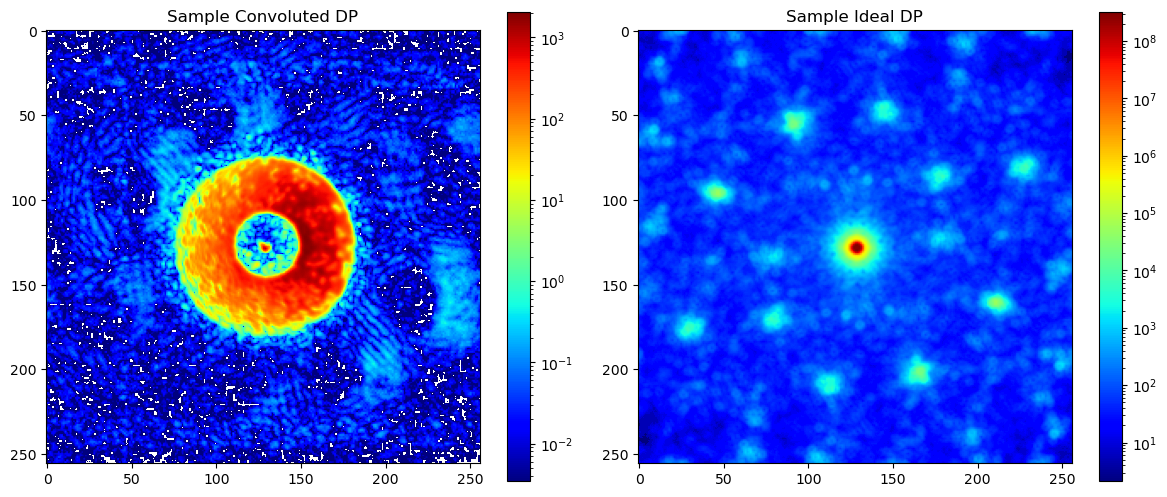

100%|██████████| 960/960 [00:00<00:00, 5685.30it/s]


No resizing...
maximum in ideal patterns: 8.906368255615234
maximum in conv patterns: 3.710855007171631
normalized maximum in ideal/output patterns: 1.0
normalized maximum in conv/input patterns: 1.0


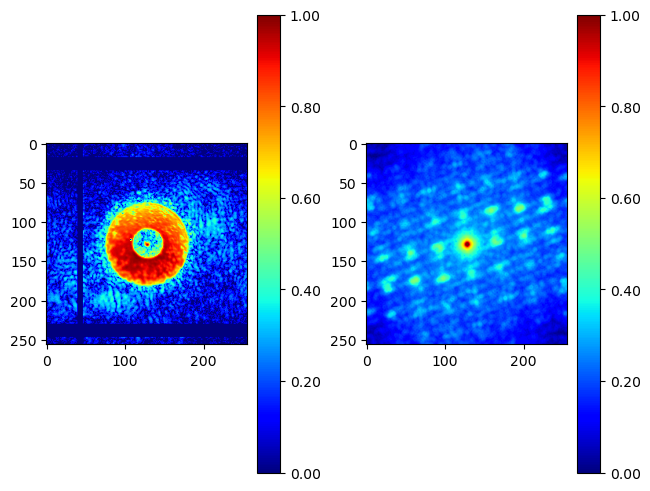

save string: Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256


In [ ]:
#shuffle data
shuffle_data=True

#resize data
red=False #Tr

# Load your detector mask as before
detector_mask = np.load(os.path.abspath(os.path.join(os.getcwd(), '../data/masks/mask_ZCB_9_3D.npy')))

# Apply both masks to each image
processed_conv_DPs = []
processed_ideal_DPs = []

# Process each image
for i in tqdm(range(len(conv_DPs))):
    # First apply the detector mask
    masked_conv = apply_mask(conv_DPs[i], detector_mask)
    masked_ideal = ideal_DPs[i]
    
    processed_conv_DPs.append(masked_conv)
    processed_ideal_DPs.append(masked_ideal)
    
# Convert to numpy arrays
processed_conv_DPs = np.array(processed_conv_DPs)
processed_ideal_DPs = np.array(processed_ideal_DPs)

#shuffle data correspondingly
if shuffle_data:
    indices = np.arange(processed_conv_DPs.shape[0])
    np.random.shuffle(indices)
    conv_DPs_shuff = processed_conv_DPs[indices]
    ideal_DPs_shuff = processed_ideal_DPs[indices]
else:
    conv_DPs_shuff = processed_conv_DPs
    ideal_DPs_shuff = processed_ideal_DPs


## Log transform and normalize data.

In [ ]:
# separate amplitude and phase
# thus network used the intensity patterns
log_conv = log10_custom(conv_DPs_shuff)
log_ideal = log10_custom(ideal_DPs_shuff)

# resize data
if red:
    print("Resizing...")
    log_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(log_ideal)])
    log_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(log_conv)])
else:
    print("No resizing...")
    log_ideal_red=log_ideal
    log_conv_red=log_conv

ri=random.randint(0,len(log_conv))
print(f'maximum in ideal patterns: {np.max(log_ideal_red[ri])}')
print(f'maximum in conv patterns: {np.max(log_conv_red[ri])}')

# Scale factors
#NORMALIZE OUTPUT FROM 0 to 1
ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in log_ideal_red])
ideal_constants=np.asarray([(np.min(a)) for a in log_ideal_red])
log_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in log_ideal_red])

# #NORMALIZE INPUT FROM 0 to 1
conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in log_conv_red])
conv_constants=np.asarray([(np.min(a)) for a in log_conv_red])
log_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in log_conv_red])

print(f'normalized maximum in ideal/output patterns: {np.max(log_ideal_red[0])}')
print(f'normalized maximum in conv/input patterns: {np.max(log_conv_red[0])}')

fig,ax=plt.subplots(1,2,layout='constrained')
im1=ax[1].imshow(log_ideal_red[0])#,norm=colors.LogNorm())
plt.colorbar(im1, ax=ax[1], format='%.2f')
im2=ax[0].imshow(log_conv_red[0])#,norm=colors.LogNorm())
plt.colorbar(im2, ax=ax[0], format='%.2f')
plt.show()



## Save preprocessed data

In [ ]:
if save:
    np.savez(path / f'ptycoSAXSNN/example/02_Preprocess/preprocessed_sim_{save_string}.npz',log_conv_red=log_conv_red,log_ideal_red=log_ideal_red)
    print('save string:', save_string)
    #print(f'saved preprocessed data to {os.path.abspath(os.path.join(os.getcwd(), f'/scratch/preprocessed_sim_{save_string}.npz'))}')